<a href="https://colab.research.google.com/github/obaidah3/eeg_authentication_system/blob/main/eeg_authentication_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install numpy pandas mne tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 8.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.

# **EEG-Based Universal and Privacy-Preserving Authentication System**

**Original Paper:** [Towards a universal and privacy preserving EEG-based authentication system](https://www.nature.com/articles/s41598-022-06527-7)

## **1. Introduction**
This notebook implements the methodology proposed by Bidgoly et al. in the paper linked above (Scientific Reports, 2022). The system addresses three critical challenges in EEG biometrics:

1.  **Universality:** Capable of authenticating completely new users without retraining the model.
2.  **Privacy:** Stores an irreversible "fingerprint" vector instead of raw brainwaves, preventing the leakage of sensitive health information.
3.  **Ease of Use:** Reduces the required hardware to just three electrodes (Oz, T7, Cz) using Gram-Schmidt orthogonalization.

### **Methodology Overview**
We utilize a **Convolutional Neural Network (CNN)** not as a classifier, but as a feature extractor to generate unique "brain fingerprints." These fingerprints are authenticated using **Cosine Distance**. The system is tested on a dataset of 109 subjects, split into "Alpha" (known/training) and "Beta" (unknown/testing) groups to demonstrate universality.


![EEG authentication system.png](attachment:34eb163b-a808-41d0-b571-ce4ab589fff0.png)

In [ ]:
import os
# Set log level to '2' to print only errors (suppresses warnings and info messages)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
import mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import cosine
# Suppress MNE information messages
mne.set_log_level('WARNING')


class Config:
    # Path to the Kaggle/Physionet Dataset
    BASE_PATH = '/kaggle/input/physionet-eeg-motor-movement-imagery/files'

    # Experiment Settings
    RUN_ID = 1            # Resting Eyes Open (REO) task
    TARGET_CHANNذELS = ['Oz', 'T7', 'Cz'] # Optimal channel set determined by the paper
    WINDOW_SIZE = 160     # 1 second window at 160Hz
    STRIDE = 4            # Sliding window step for augmentation
    SAMPLE_RATE = 160     # Standard Physionet sampling rate

    # Dataset Split: Alpha (Train) vs Beta (Test/Unseen)
    # The paper trains on Alpha users to learn features, then tests on Beta users to prove universality.
    TRAIN_SUBJECTS = range(1, 90)   # Alpha users
    TEST_SUBJECTS = range(90, 109)  # Beta users (Unseen)

    # Training Hyperparameters
    BATCH_SIZE = 64
    EPOCHS = 30

2025-11-29 18:58:21.112931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764442701.282433      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764442701.332802      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **2. Data Preprocessing**

The preprocessing pipeline converts raw EEG signals into a format suitable for deep learning. A key contribution of the paper is the use of **Gram-Schmidt Orthogonalization** to reduce channel redundancy, allowing the system to achieve high accuracy with only 3 channels.

### **2.1 Gram-Schmidt Orthogonalization**
To ensure the selected channels (Oz, T7, Cz) provide distinct, non-redundant features, we apply the Gram-Schmidt process. For a set of channel vectors, this process projects each vector onto the orthogonal complement of the previous ones.

The orthogonalized signal $v_{k}^{i}$ for channel $k$ at step $i$ is calculated as:

$$
v_{k}^{i} \triangleq \hat{u}_{k} - \sum_{j=1}^{i-1} \frac{(v^{j}, \hat{u}_{k})}{(v^{j}, v^{j})} v^{j}
$$

Where:
* $\hat{u}_{k}$ is the normalized signal of the $k$-th channel.
* $v^{j}$ is the orthogonalized signal from the previous step.
* $(a, b)$ denotes the dot product of vectors $a$ and $b$.

### **2.2 Normalization & Segmentation**
1.  **Normalization:** Each channel is normalized using Min-Max scaling to the range $[0, 1]$.
2.  **Segmentation:** We use a sliding window of size $T=160$ (1 second) with a stride of $\delta=4$ to slice the continuous EEG recording into overlapping image-like segments.



![sliding window.png](attachment:9c0e9420-7215-48ad-8fcf-d6f094adec92.png)



In [ ]:
def gram_schmidt(vectors):
    """
    Orthogonalizes channels to remove correlation (Paper Method).
    Args:
        vectors (np.array): Shape (n_samples, n_channels)
    Returns:
        np.array: Orthogonalized vectors
    """
    basis = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        v = vectors[:, i]
        u = v.copy()
        for j in range(i):
            prev_u = basis[:, j]
            norm_prev = np.dot(prev_u, prev_u)
            if norm_prev > 1e-10:
                projection = (np.dot(v, prev_u) / norm_prev) * prev_u
                u -= projection
        basis[:, i] = u
    return basis

def create_segments(data, label, window_size, stride):
    """Slice continuous signal into training segments."""
    n_samples = data.shape[0]
    segments = []
    labels = []
    for start in range(0, n_samples - window_size + 1, stride):
        end = start + window_size
        segment = data[start:end, :]
        if segment.shape == (window_size, data.shape[1]):
            segments.append(segment)
            labels.append(label)
    return segments, labels

def load_data_for_subjects(subject_list, config):
    """Loads, orthogonalizes, and segments data for a list of subjects."""
    all_X = []
    all_y = []

    print(f"Loading data for {len(subject_list)} subjects...")

    for i, subject_id in enumerate(subject_list):
        try:
            # Construct file path
            path = f"{config.BASE_PATH}/S{subject_id:03d}/S{subject_id:03d}R{config.RUN_ID:02d}.edf"
            if not os.path.exists(path):
                continue

            # Load & Resample
            raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
            if raw.info['sfreq'] != config.SAMPLE_RATE:
                raw.resample(config.SAMPLE_RATE, npad="auto", verbose=False)

            mne.rename_channels(raw.info, lambda x: x.strip('.'))
            try:
                raw.pick(config.TARGET_CHANNELS)
            except ValueError:
                continue

            data = raw.get_data().T

            # Apply Gram-Schmidt & Scaling
            data = gram_schmidt(data)
            scaler = MinMaxScaler(feature_range=(0, 1))
            data = scaler.fit_transform(data)

            # Create Segments
            X, y = create_segments(data, i, config.WINDOW_SIZE, config.STRIDE)

            all_X.extend(X)
            all_y.extend(y)

        except Exception as e:
            print(f"  Error S{subject_id}: {e}")

    return np.array(all_X), np.array(all_y)

###  The input shape is $(160, 3)$, representing 160 time steps across 3 EEG channels.

![image.png](attachment:fb122c8b-49fd-4a80-8590-eaf42c6f511b.png)

## **3. Deep Learning Model Architecture**

The system uses a **Convolutional Neural Network (CNN)** designed to extract spatial-temporal features from the EEG segments.

The architecture is split into two logical parts:
1.  **Fingerprinting Layers:** Three convolutional blocks followed by a dense layer. This section extracts the unique "fingerprint" vector from the input signal.
2.  **Identification Layers:** A classification head (Softmax) used *only* during training to force the model to learn discriminative features. It is discarded during the authentication phase.

The input shape is $(160, 3)$, representing 160 time steps across 3 EEG channels.



In [ ]:
def build_cnn_model(input_shape, num_classes):
    """
    Implements the 2D CNN Architecture.
    Treats EEG signal (160x3) as a 2D image.
    """
    inputs = tf.keras.Input(shape=input_shape) # (160, 3)

    # Reshape: Add "Color Channel" dim -> (160, 3, 1)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)

    # Block 1
    x = tf.keras.layers.Conv2D(32, kernel_size=(5, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Block 2
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Block 3
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Feature Vector Layer (The Fingerprint)
    # This is the bottleneck layer that generates the unique ID
    features = tf.keras.layers.Dense(128, activation='relu', name='fingerprint_layer')(x)

    # Classification Head (Training only)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(features)

    model = tf.keras.Model(inputs, outputs)
    return model

## **4. Experiment 1: Training the Feature Extractor**

We train the model using **Subjects 1-89 (Alpha Users)**. The model learns to classify these users, which indirectly teaches the `fingerprint_layer` to extract highly discriminative features from brainwaves.

Once training is complete, we extract the **Fingerprinting Model** by truncating the network at the feature layer.

In [ ]:
# --- Load Training Data ---
cfg = Config()
print("Phase 1: Loading Training Data (Subject 1-89)...")
X_train, y_train = load_data_for_subjects(cfg.TRAIN_SUBJECTS, cfg)

# Prepare Data
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
idx = np.arange(len(X_train))
np.random.shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]

# Build & Train Model
model = build_cnn_model((cfg.WINDOW_SIZE, 3), len(cfg.TRAIN_SUBJECTS))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nPhase 2: Training Model...")
history = model.fit(X_train, y_train,
                    epochs=cfg.EPOCHS,
                    batch_size=cfg.BATCH_SIZE,
                    validation_split=0.1,
                    verbose=1)

# Create Extractor (Remove classification head)
fingerprint_model = tf.keras.Model(inputs=model.input,
                                   outputs=model.get_layer('fingerprint_layer').output)

Phase 1: Loading Training Data (Subject 1-89)...
Loading data for 89 subjects...


I0000 00:00:1764442722.804123      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Phase 2: Training Model...
Epoch 1/30


I0000 00:00:1764442726.756036     115 service.cc:148] XLA service 0x2d995880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764442726.756698     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764442727.116007     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  45/3004 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0420 - loss: 4.3374 

I0000 00:00:1764442729.273730     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3004/3004 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.6971 - loss: 1.1802 - val_accuracy: 0.4672 - val_loss: 3.8441
Epoch 2/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9786 - loss: 0.0650 - val_accuracy: 0.6313 - val_loss: 2.3608
Epoch 3/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9885 - loss: 0.0371 - val_accuracy: 0.9108 - val_loss: 0.3649
Epoch 4/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9918 - loss: 0.0254 - val_accuracy: 0.9823 - val_loss: 0.0696
Epoch 5/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9947 - loss: 0.0174 - val_accuracy: 0.9987 - val_loss: 0.0057
Epoch 6/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.8514 - val_loss: 0.8178
Epoch 7/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9199 - val_loss: 0.3352
Epoch 8/30
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9969 - loss: 0.0104 - val

## **5. Experiment 2: Universality Evaluation on Unseen Users**

To prove universality, we test the system on **Subjects 90-109 (Beta Users)**. These users were not included in the training set.

### **Authentication Logic**
The system authenticates a user by comparing the Cosine Distance between their stored template $s$ and a new probe sample $a$. The authentication function $I(a, s)$ is defined as:

$$
I(a, s) = \begin{cases}
\text{true} & \text{distance}(s, f(a)) < \text{threshold} \\
\text{false} & \text{otherwise}
\end{cases}
$$

We calculate the **Equal Error Rate (EER)** to determine the system's performance. The EER is the point where the False Acceptance Rate (FAR) equals the False Rejection Rate (FRR).


Phase 3: Loading Test Data...
Loading data for 29 subjects...

--- Starting Authentication Evaluation on 29 Unseen Users ---
Generating embeddings...
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

=== FINAL RESULTS ===
AUC Score: 0.9956
EER (Equal Error Rate): 0.0297 (2.97%)
Optimal Similarity Threshold: 0.7404


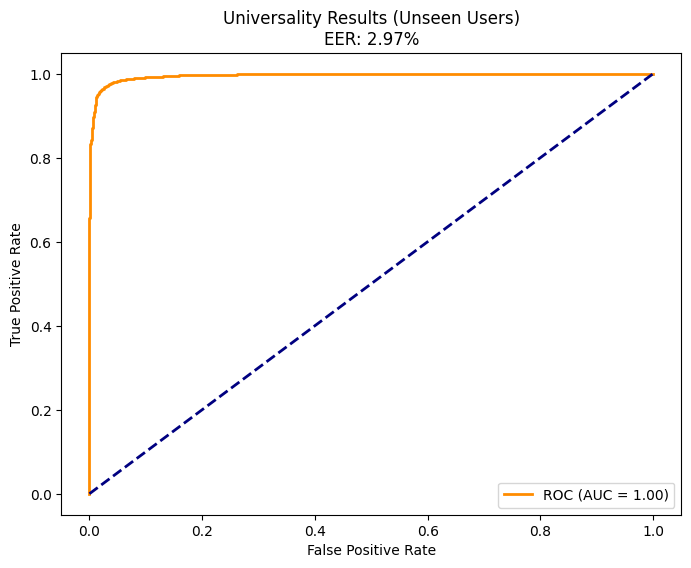

In [ ]:
def evaluate_authentication(model, X_test, y_test):
    """
    Calculates ROC and EER for Universality (Unseen Users).
    """
    unique_users = np.unique(y_test)
    all_gen_scores = []
    all_imp_scores = []

    print(f"\n--- Starting Authentication Evaluation on {len(unique_users)} Unseen Users ---")

    # Generate Embeddings for all test data
    print("Generating embeddings...")
    embeddings = model.predict(X_test, batch_size=128, verbose=1)

    for user_idx in unique_users:
        user_indices = np.where(y_test == user_idx)[0]
        impostor_indices = np.where(y_test != user_idx)[0]

        # Split: 50% Enrollment, 50% Probe
        split_point = len(user_indices) // 2
        enroll_indices = user_indices[:split_point]
        probe_indices = user_indices[split_point:]

        if len(enroll_indices) == 0 or len(probe_indices) == 0:
            continue

        # 1. Create Template (Average of enrollment samples)
        enroll_vecs = embeddings[enroll_indices]
        template = np.mean(enroll_vecs, axis=0)

        # 2. Genuine Scores (Distance to own template)
        probe_vecs = embeddings[probe_indices]
        for vec in probe_vecs:
            dist = cosine(template, vec)
            all_gen_scores.append(dist)

        # 3. Impostor Scores (Distance to random others)
        np.random.shuffle(impostor_indices)
        sel_imp_indices = impostor_indices[:100]
        imp_vecs = embeddings[sel_imp_indices]
        for vec in imp_vecs:
            dist = cosine(template, vec)
            all_imp_scores.append(dist)

    # --- Metrics & ROC Curve ---
    y_true = [1] * len(all_gen_scores) + [0] * len(all_imp_scores)
    # Convert Distance to Similarity (1 - Distance) for ROC
    y_scores = (1 - np.array(all_gen_scores)).tolist() + (1 - np.array(all_imp_scores)).tolist()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate Equal Error Rate (EER)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.absolute((fnr - fpr)))
    EER = fpr[eer_idx]
    optimal_threshold = thresholds[eer_idx]

    print(f"\n=== FINAL RESULTS ===")
    print(f"AUC Score: {roc_auc:.4f}")
    print(f"EER (Equal Error Rate): {EER:.4f} ({EER*100:.2f}%)")
    print(f"Optimal Similarity Threshold: {optimal_threshold:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Universality Results (Unseen Users)\nEER: {EER:.2%}')
    plt.legend(loc="lower right")
    plt.show()

    return optimal_threshold

# Run Evaluation
print("\nPhase 3: Loading Test Data...")
X_test, y_test = load_data_for_subjects(cfg.TEST_SUBJECTS, cfg)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

optimal_thresh = evaluate_authentication(fingerprint_model, X_test, y_test)

## **6. Live Demo Application**

This section simulates a real-world deployment. It allows us to:
1.  **Enroll** a user (creating and storing their template).
2.  **Authenticate** a genuine user (matching their new brainwaves to the template).
3.  **Reject** an impostor (failing to match an unregistered user).

In [ ]:
class EEGSecuritySystem:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
        self.database = {}
        print(f"\n--- System Online (Threshold: {self.threshold:.4f}) ---")

    def _get_embedding(self, data):
        if len(data) == 0: raise ValueError("Empty data input")
        if data.ndim == 2: data = np.expand_dims(data, axis=0)
        vectors = self.model.predict(data, verbose=0)
        return np.mean(vectors, axis=0)

    def enroll_user(self, user_id, raw_data):
        try:
            template = self._get_embedding(raw_data)
            self.database[user_id] = template
            print(f"✅ Enrolled User {user_id}")
        except:
            print(f"⚠️ Failed to enroll User {user_id}")

    def identify_user(self, raw_data):
        if len(raw_data) == 0: return
        probe = self._get_embedding(raw_data)

        best_id = None
        best_sim = -1

        for uid, template in self.database.items():
            sim = 1 - cosine(template, probe)
            if sim > best_sim:
                best_sim = sim
                best_id = uid

        if best_sim >= self.threshold:
            print(f"🔓 Access GRANTED: Identified as User {best_id} (Score: {best_sim:.3f})")
        else:
            print(f"🔒 Access DENIED: Unknown User (Best match {best_id} was only {best_sim:.3f})")

# Run Demo
print("\nPhase 4: Running Live Demo...")
app = EEGSecuritySystem(fingerprint_model, threshold=optimal_thresh)

available_users = np.unique(y_test)
if len(available_users) >= 2:
    # Enroll User A
    user_A = available_users[0]
    data_A_enroll = X_test[y_test == user_A][:100]
    data_A_probe = X_test[y_test == user_A][100:]
    app.enroll_user(user_A, data_A_enroll)

    # Test User A (Should Pass)
    print(f"\n[Test] User {user_A} attempting login...")
    app.identify_user(data_A_probe)

    # Test User B (Should Fail - Impostor)
    user_B = available_users[1]
    data_B = X_test[y_test == user_B]
    print(f"\n[Test] Unregistered User {user_B} attempting login...")
    app.identify_user(data_B)


Phase 4: Running Live Demo...

--- System Online (Threshold: 0.7404) ---
✅ Enrolled User 0

[Test] User 0 attempting login...
🔓 Access GRANTED: Identified as User 0 (Score: 0.967)

[Test] Unregistered User 1 attempting login...
🔒 Access DENIED: Unknown User (Best match 0 was only 0.510)
